# **Tiny Imagenet - Super Resolution**

We will be working on super-resolution and not classification tasks in this NB.

In [1]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from fastprogress import progress_bar
from glob import glob
import warnings; warnings.filterwarnings('ignore')

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Data Processing**

Copying over sections from the previous NBs.

In [4]:
path_data = Path('data')
path = path_data/'tiny-imagenet-200'
bs = 512
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [5]:
path

Path('data/tiny-imagenet-200')

**For tasks like super-resolution (and image reconstruction in general) we must ensure that both the dependant and independant data receive the same amount of data augmentation.** 

In [6]:
tfms = nn.Sequential(T.Pad(8), T.RandomCrop(64), T.RandomHorizontalFlip())

In [7]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

- We will add random erasing just for the training set. This makes the task of learning more difficult for the model and forces it to learn to replace missing pixels.
- In `TfmDS` the argument `tfmx` applies transformations / augmentations to the independant variable. In turn `tfmx()` applies `TF.resize()` to the 32x32 image, making it 64x64 and interpolates. This effectively doubles up the pixel count. 

In [8]:
# We will add random erasing just for the training set. This makes the task of learning more
# difficult for the model and forces it to learn to replace missing pixels.
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32))[None]
    x = F.interpolate(x, scale_factor=2)
    if erase: x = rand_erase(x)
    return x[0]

In [9]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [13]:
xb,yb = next(iter(dls.train))

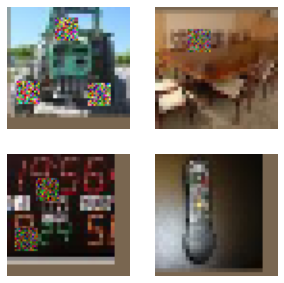

In [14]:
show_images(denorm(xb[:4]), imsize=2.5)

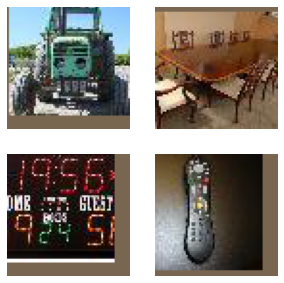

In [15]:
show_images(denorm(yb[:4]), imsize=2.5)

## **Implementing a Denoising AutoEncoder**

The `upblock` basically doubles the pixels through sequential upsampling. This is followed by an extra Resblock at the end to return 3 channels.

So this model basically takes images which are squeezed into smaller representations, and then these representations are brought back up to their super-resolution target. 

In [16]:
def upblock(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [17]:
def get_model(act=act_gr, nfs=(32, 64, 128, 256, 512, 1024), norm=nn.BatchNorm2d, drop=0.1):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) 
               for i in range(len(nfs)-1)]
    layers += [upblock(nfs[i], nfs[i-1], act=act, norm=norm) 
               for i in range(len(nfs)-1, 0, -1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers).apply(iw)

In [18]:
iw = partial(init_weights, leaky=0.1)

In [19]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

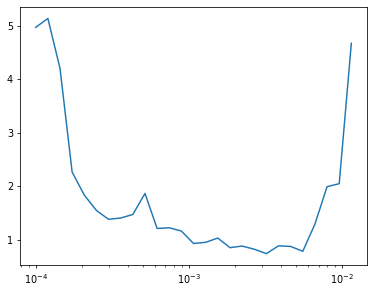

In [20]:
Learner(get_model().apply(iw), dls, F.mse_loss, cbs=lr_cbs, 
        opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [21]:
epochs = 5
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.694,0,train
0.399,0,eval
0.340,1,train
0.290,1,eval
0.279,2,train
0.247,2,eval
0.251,3,train
0.230,3,eval
0.241,4,train
0.226,4,eval


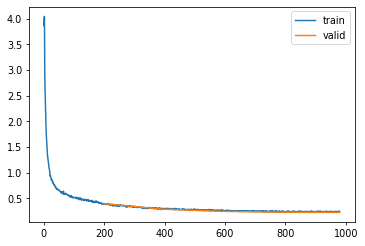

In [22]:
learn.fit(epochs)

loss,epoch,train
0.227,0,eval


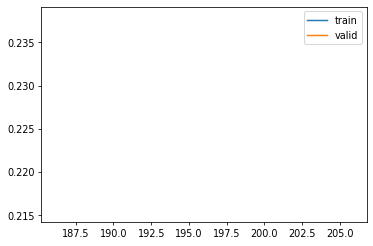

In [23]:
# predictions, targets and inputs extracted from the model
p, t, inp = learn.capture_preds(inps=True)

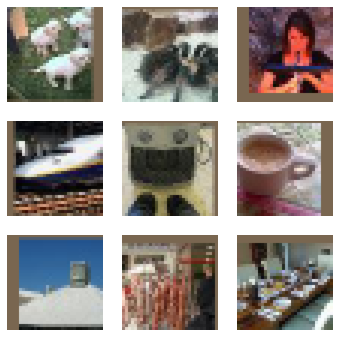

In [24]:
show_images(denorm(inp[:9]), imsize=2)

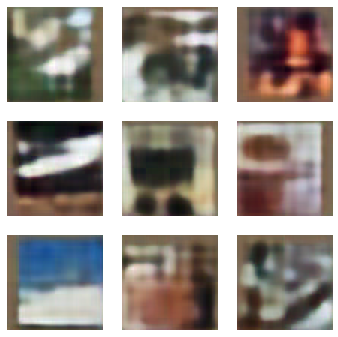

In [25]:
show_images(denorm(p[:9]), imsize=2)

These results are quite bad!!

The fundamental problem lies with the AutoEncoder, especially smaller AutoEncoders to carry out the task of super-resolution.

Instead of adding additional complexity, we can instead simplify the model using the UNet architecture.

## **Switching Over To A UNET**

In [26]:
del(learn)
clean_mem()

The [original paper](https://arxiv.org/abs/1505.04597) which introduced UNets in 2015, for use in medical imaging describes the architecture consisting... 

>.. of a contracting path to capture context and a symmetric expanding path that enables precise localization.

We have referred to the "contracting path" as the **downsampling path** in previous NBs. Conversely, the "symmetric expanding path" is referred to as the **upsampling path**. The original paper used Convolution blocks in both upsampling and downsampling paths, whereas we have used ResNet blocks.

During each stage of the upsampling path, the architecture copies over the activations from the opposite downsampling path. This ensures that the structure of the original image is retained for our super-resolution exercise.

In [27]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32, 64, 128, 256, 512, 1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        # Downsampling path
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        # Upsampling path
        self.up = nn.ModuleList([upblock(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1, 0, -1)])
        # Final 3 channel block
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        # Save first input before starting downsampling. 
        layers = []
        layers.append(x)
        x = self.start(x)
        # For each layer in the downsampling path, save activations.
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        # During upsampling, instead of concatenating simply add the saved activations from 
        # the earlier steps
        for i, l in enumerate(self.up):
            if i!=0: x += layers[n-i] # Skip first layer.
            x = l(x)
        # At the end, at add back the first layer and pass through the ResBlock.
        return self.end(x + layers[0])

In [28]:
# Zero out the weights and biases of the model.
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [29]:
model = TinyUnet()

In [30]:
last_res = model.up[-1]           # End of the upsampling path
zero_wgts(last_res.convs[-1][-1]) # Zero out the last convolution
zero_wgts(last_res.idconv[0])     # Zero out the last ID connection
zero_wgts(model.end.convs[-1][-1])# Zero out the weights for the end block 

An alternative approach to the above cellblock is that instead of zeroing out the final blocks, we can multiply the weights and activations with a very small number such as `1e-3` to guarantee that there is no signal loss.

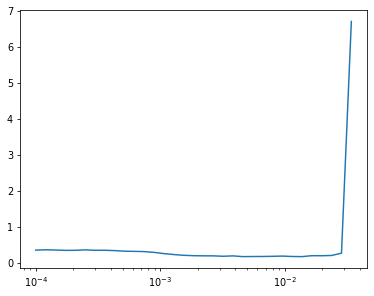

In [31]:
Learner(model, dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [32]:
model = TinyUnet()

In [33]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

In [34]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.163,0,train
0.086,0,eval
0.107,1,train
0.082,1,eval
0.097,2,train
0.080,2,eval
0.094,3,train
0.079,3,eval
0.092,4,train
0.078,4,eval


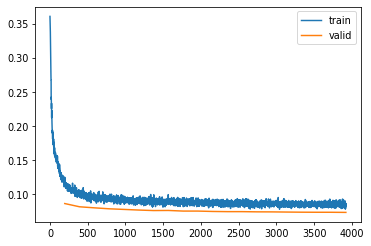

In [35]:
learn.fit(epochs)

In [41]:
torch.save(learn.model, 'models/superres-cross')

loss,epoch,train
0.073,0,eval


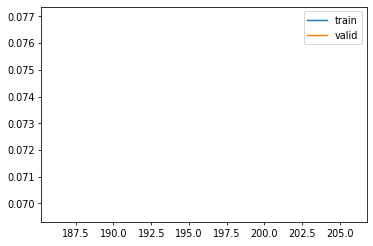

In [37]:
p, t, inp = learn.capture_preds(inps=True)

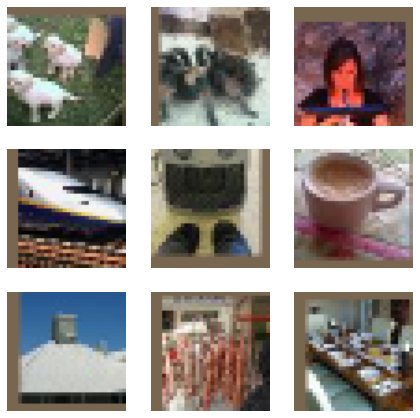

In [38]:
#Inputs
show_images(denorm(inp[:9]), imsize=2.5)

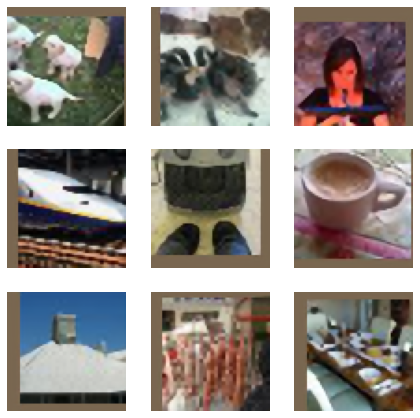

In [39]:
# Outputs
show_images(denorm(p[:9]), imsize=2.5)

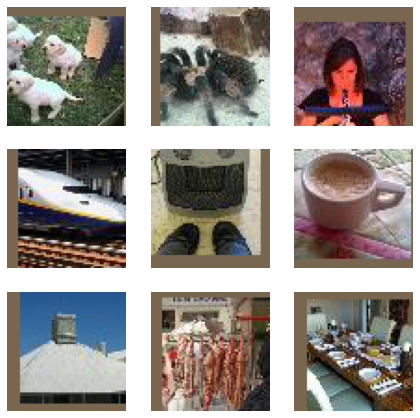

In [40]:
# Training samples.
show_images(denorm(t[:9]), imsize=2.5)

Although we haven't recreated the originals, this approach's outputs are a marked improvement over the autoencoder approach.

However, using MSE as a loss function for a model such as this is incorrect and results in blurry outputs like we saw above. This is a result of averaging the loss during the training steps.

To fix this, **Perceptual Loss** is the recommended metric.

## **Perceptual Loss To Replace MSE**

>### **[What Are Perceptual Loss Functions?](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function)**
>
>**Perceptual loss** functions are designed to capture perceptual differences between images, such as content and style discrepancies, which are not always evident at the pixel level. They are often employed in tasks where the goal is to generate images that are visually pleasing to humans, such as in neural style transfer, super-resolution, and image synthesis.
>
>The core idea behind perceptual loss is to use the feature maps from various layers of a CNN, which has been pre-trained on a large dataset like ImageNet. By extracting these feature maps from both the target image and the generated image, we can compute the difference in the high-level features that the network has learned to detect, such as edges, textures, and patterns.
>
>### **How Perceptual Loss Functions Work**
>
>One common approach to implementing perceptual loss involves using a pre-trained VGG network, a type of CNN that has been shown to be effective in capturing image content and style. The perceptual loss function typically consists of two main components:
>
>    **Content Loss**: This measures how much the feature maps of the generated image differ from the feature maps of the target image. By minimizing this loss, the generated image is encouraged to preserve the content of the target image.
>
>    **Style Loss**: This measures the difference in the correlation between feature maps, capturing the texture and style information. Minimizing style loss ensures that the style of the generated image matches the style of a reference image.
>
>During the training process, the generated image is passed through the pre-trained network, and its feature maps are extracted at predetermined layers. The same is done for the target and style reference images. The perceptual loss is then calculated by comparing these feature maps using a distance metric, such as the Euclidean distance.

In [42]:
# Classifier model
cmodel = torch.load('models/imgnet-tiny-basic-25')# Train and fill in imgnet-tiny-custom model. For now
                              # lets use the base tiny imgnet model.

In [43]:
xb, yb = next(iter(dls.valid))
with torch.autocast('cuda'), torch.no_grad():
    preds = to_cpu(cmodel(yb.cuda().half()))
preds.shape

torch.Size([1024, 200])

In [44]:
# Using the same code as before for the SynSets
id2str = (path/'wnids.txt').read_text().splitlines()
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k, v in all_synsets if k in id2str}

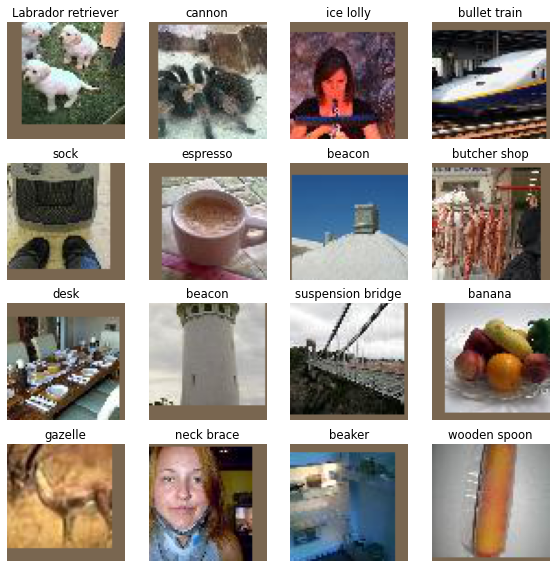

In [45]:
# Titles are off since we are working on model predictions and the model had ~60% accuracy
titles = [synsets[id2str[o]] for o in preds.argmax(dim=1)]
show_images(denorm(yb[:16]), imsize=2.5, titles=titles[:16])

In [46]:
cmodel

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (act): GeneralRelu()
  )
  (2): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Gen

In [47]:
# Based on the architecture above, we will grab the end of the 3rd Resblock
for i in range(4, len(cmodel)): del(cmodel[4])

In [49]:
with torch.autocast('cuda'), torch.no_grad():
    feat = to_cpu(cmodel(yb.cuda())).float()
    t = to_cpu(learn.model(yb.cuda())).float()
    pred_feat = to_cpu(cmodel(t.cuda())).float()

feat.shape

torch.Size([1024, 256, 8, 8])

The intuitive approach is to ensure that the features in `cmodel` generally have the same sign as features in the `learn.model`.

Moving onto the loss function:

In [51]:
# Function to calculate MSE Loss b/w inputs and targets, plus the MSE Loss
# for the features we get out of the cmodel and the features of the target image.
def comb_loss(inp, tgt):
    with torch.autocast('cuda'):
        # Target features must not get modified i.e. no_grad()
        with torch.no_grad(): tgt_feat = cmodel(tgt).float() 
        # Inputs with have grad()    
        inp_feat = cmodel(inp).float()
    feat_loss = F.mse_loss(inp_feat, tgt_feat)
    return F.mse_loss(inp, tgt) + feat_loss/10 # standardize feature loss for simplicity.

In [52]:
def get_unet():
    moddel = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

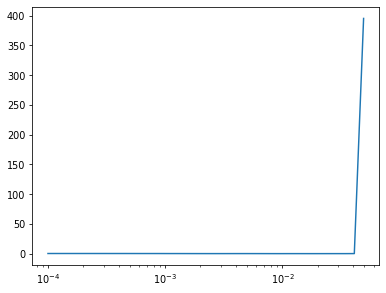

In [53]:
Learner(get_unet(), dls, comb_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [54]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_unet(), dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.207,0,train
0.132,0,eval
0.171,1,train
0.106,1,eval
0.125,2,train
0.098,2,eval
0.115,3,train
0.095,3,eval
0.112,4,train
0.094,4,eval


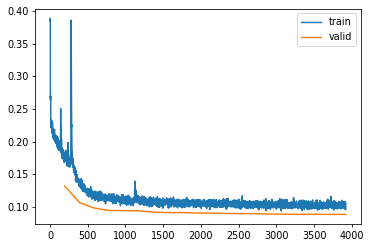

In [55]:
learn.fit(epochs)

loss,epoch,train
0.088,0,eval


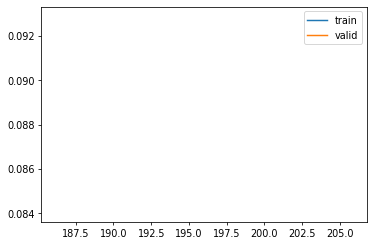

In [56]:
p, t, inp = learn.capture_preds(inps=True)

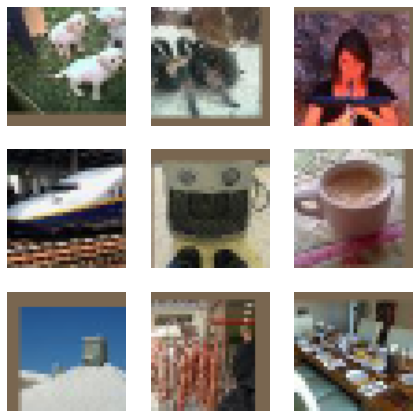

In [59]:
show_images(denorm(inp[:9]), imsize=2.5)

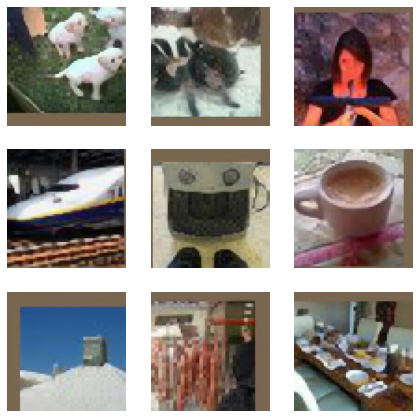

In [60]:
show_images(denorm(p[:9]), imsize=2.5)

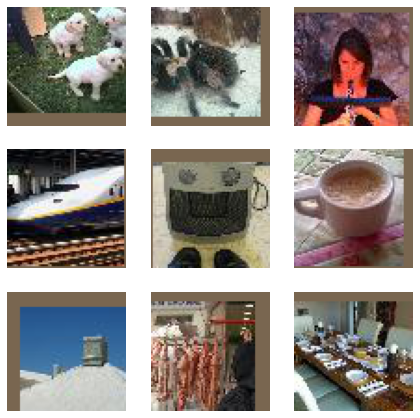

In [61]:
show_images(denorm(t[:9]), imsize=2.5)